# XGBoost Classifier
### Author: Ehsan Gharib-Nezhad



In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# # Imbalance data Handling ___________________________________________________
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

import xgboost as xgb
from xgboost import XGBClassifier

from myfunctions import *

In [2]:
df = pd.read_csv('../datasets/text_processed_all_posts_combined_imbalanced_v2.csv')
is_balanced = False # set True is the dataset is balanced!!! 

In [3]:
df.head(3)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,post,post2,stemmed,is_Covid19positive
0,I am constantly seeing people asking about people’s experiences so I figured now we can go to one place and stop spamming the AMA and ask Reddit’s subs.,For those that have tested positive I hope every single one of you feels better soon!,COVID19positive,1584148032,the1andonlyjoja,191,1,True,2020-03-13 18:07:12,For those that have tested positive I hope every single one of you feels better soon,For tested positive I hope every single one feels better soon,for test posit i hope everi singl one feel better soon,1
1,How severe are your guys' symptoms?,"I have no idea if I've got the coronavirus, or it's just a cold etc. I've got a runny nose and coughing quite a lot, and a bit of a headache. I don't want to go out in case I do have it and I give it to other people. Are your symptoms debilitating?",COVID19positive,1584358828,RocketFrasier,0,1,True,2020-03-16 04:40:28,I have no idea if I ve got the coronavirus or it s just a cold etc I ve got a runny nose and coughing quite a lot and a bit of a headache I don t want to go out in case I do have it and I give it to other people Are your symptoms debilitating,I idea I got coronavirus cold etc I got runny nose coughing quite lot bit headache I want go case I I give people Are symptoms debilitating,i idea i got coronaviru cold etc i got runni nose cough quit lot bit headach i want go case i i give peopl are symptom debilit,1
2,How severe are your symptoms?,"I have no idea if I've got the coronavirus, or it's just a cold etc. I've got a runny nose and coughing quite a lot, and a bit of a headache. I don't want to go out in case I do have it and I give it to other people. My symptoms feel practically the same as a normal cold/flu, other than last night where my eyes hurt a bit, so I wasn't able to sleep. Are your symptoms debilitating?",COVID19positive,1584358937,RocketFrasier,42,1,True,2020-03-16 04:42:17,I have no idea if I ve got the coronavirus or it s just a cold etc I ve got a runny nose and coughing quite a lot and a bit of a headache I don t want to go out in case I do have it and I give it to other people My symptoms feel practically the same as a normal cold flu other than last night where my eyes hurt a bit so I wasn t able to sleep Are your symptoms debilitating,I idea I got coronavirus cold etc I got runny nose coughing quite lot bit headache I want go case I I give people My symptoms feel practically normal cold flu last night eyes hurt bit I able sleep Are symptoms debilitating,i idea i got coronaviru cold etc i got runni nose cough quit lot bit headach i want go case i i give peopl my symptom feel practic normal cold flu last night eye hurt bit i abl sleep are symptom debilit,1


### Set up X and Y

In [4]:
X = df['stemmed']
y = df['is_Covid19positive']

In [5]:
#check baseline:

y.value_counts(normalize = True)

1    0.929298
0    0.070702
Name: is_Covid19positive, dtype: float64

## __Note__: This dataset is unbalanced and so the classification results are expected to be affected by this issue! To improve this, RandomOverSampler is used.

#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
# Model 1: Using `XGBClassifier` simple training procedure 

steps:
1. train test split
2. count vectorizer
3. RandomOverSampler
4. train LogisticRegression model
5. check Feature Coefficients/importnace for selecting them
6. assess classification results

### train test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    shuffle=True,
                                                    random_state = 42)

In [7]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.929288
 0    0.070712
 Name: is_Covid19positive, dtype: float64,
 1    0.929331
 0    0.070669
 Name: is_Covid19positive, dtype: float64)


### Use count vectorizer

In [8]:
cvec = CountVectorizer()

In [9]:
Xcv_train = cvec.fit_transform(X_train)
Xcv_test  = cvec.transform(X_test)

### For imbalanced case

In [10]:
ros = RandomOverSampler()

Xcv_train_balanced , y_train_balanced = ros.fit_resample(Xcv_train, y_train)

In [11]:
# The y_train dataset is balanced now!!!
y_train_balanced.value_counts()

1    23077
0    23077
Name: is_Covid19positive, dtype: int64

### Apply LogisticRegression

In [12]:
xgb_1 = XGBClassifier(random_state = 42)

In [13]:
xgb_1.fit(Xcv_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [14]:
# accuracy
xgb_1.score(Xcv_train, y_train), xgb_1.score(Xcv_test, y_test)

(0.9898924817782789, 0.9759603769026335)

# Confusion Matrix

Score on training set: 0.9898924817782789
Score on testing set: 0.9759603769026335
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       585
           1       0.98      0.99      0.99      7693

    accuracy                           0.98      8278
   macro avg       0.94      0.86      0.90      8278
weighted avg       0.97      0.98      0.97      8278



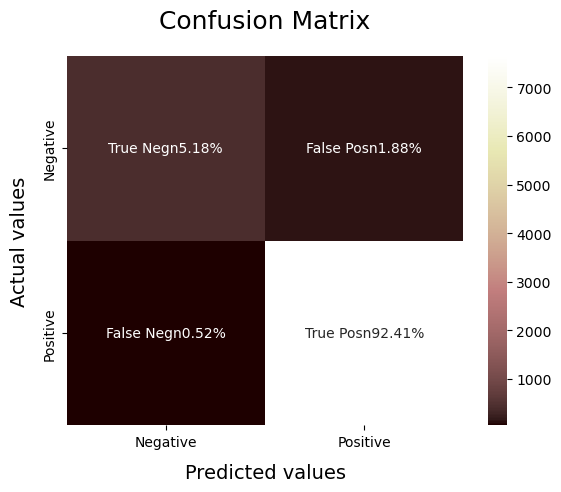

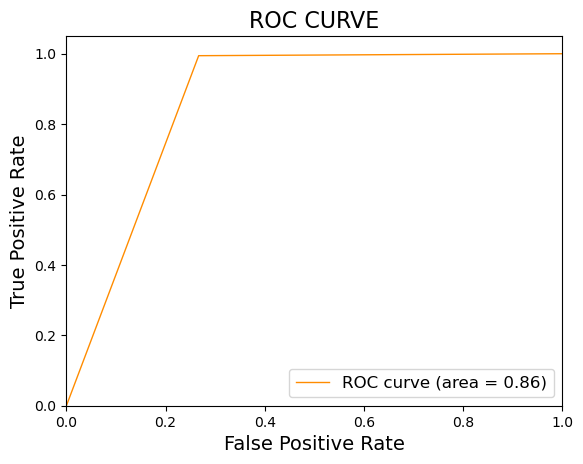

In [15]:
# View confusion matrix
model_Evaluate(xgb_1, Xcv_train, Xcv_test, y_train, y_test)

# Plot Feature Coefficient

In [16]:
#create a dataframe for our X_train_cv to use later:

df_features = pd.DataFrame(Xcv_train_balanced.todense(), columns=cvec.get_feature_names())

In [17]:
df_features.head(5)

,aa,aaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaachooooooo,aahhh,ab,aback,abain,abandon,abat,...,zuchinni,zuckersaid,zuid,zumba,zurich,zwift,zybio,zyrtec,zz,zzzquil
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Note__: This model is trained using 19,878 features!!! In this following, the importnace of these features are investigated. 

In [18]:
f = {'Feature Name':df_features.columns,'Feature Coefficient':xgb_1.feature_importances_}
fi = pd.DataFrame(f)

fi.sort_values(by=['Feature Coefficient'], ascending = False).head(1000)

,Feature Name,Feature Coefficient
13455,prep,0.040402
16923,symptom,0.040341
16455,stock,0.037029
2443,buy,0.019847
17275,test,0.018899
...,...,...
12759,perfusli,0.000000
14822,ruddi,0.000000
12758,perfus,0.000000
12756,perfum,0.000000


In [19]:
selected_features = fi.sort_values(by=['Feature Coefficient'], ascending = False).head(10000)['Feature Coefficient']
selected_features

13455    0.040402
16923    0.040341
16455    0.037029
2443     0.019847
17275    0.018899
           ...   
16553    0.000000
16552    0.000000
16551    0.000000
16550    0.000000
16549    0.000000
Name: Feature Coefficient, Length: 10000, dtype: float32

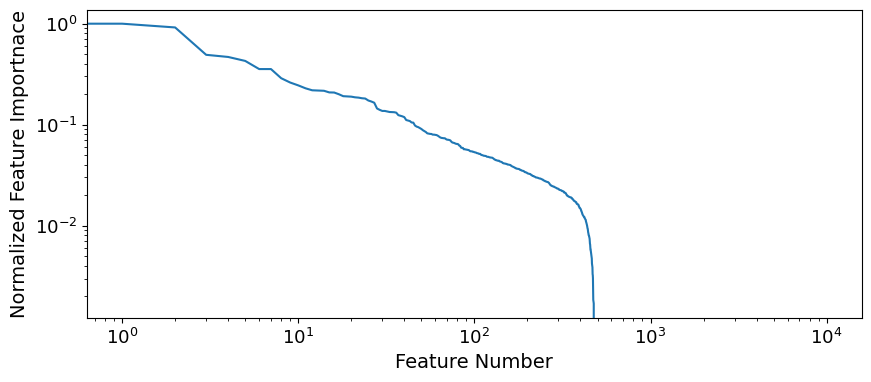

In [20]:
plt.figure( figsize=(10,4))
plt.loglog( range(len(selected_features)), selected_features/max(selected_features) )
plt.xlabel('Feature Number',fontsize=14)
plt.ylabel('Normalized Feature Importnace', fontsize = 14)
plt.tick_params('both', labelsize = 13)

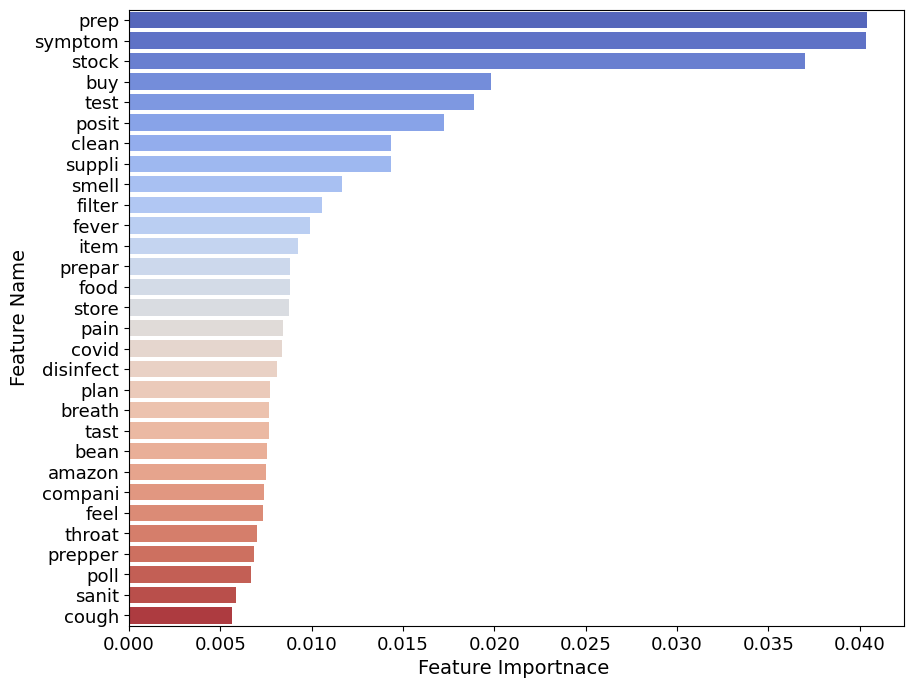

In [21]:
plt.figure( figsize=(10,8))
sns.barplot(x='Feature Coefficient',y='Feature Name', 
            data=fi.sort_values(by='Feature Coefficient', ascending=False).iloc[0:30],
            palette='coolwarm')
plt.xlabel('Feature Importnace ',fontsize=14)
plt.ylabel('Feature Name', fontsize = 14)
plt.tick_params('both', labelsize = 13)

__Figure Caption__: Words like _posit_ (i.e., positive), _covid_, _poll_, _contract_, and _symptom_ are the top words/features that are used to discrimiate between posts from subReddit Covid19Positive vs. PandemicPrep.    

### 
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
# XGBClassifier model with feature selection

In [23]:
dic = {}
for top_features_num in [10, 50, 100, 200, 300, 500, 800, 1000]:
    top_features = list(fi.sort_values(by=['Feature Coefficient'], ascending = False).head(top_features_num)['Feature Name'].values)
    Xcv_train_2 = pd.DataFrame(Xcv_train.todense(), columns=cvec.get_feature_names())[top_features]
    Xcv_test_2 = pd.DataFrame(Xcv_test.todense(), columns=cvec.get_feature_names())[top_features]
    #
    ros = RandomOverSampler()
    Xcv_train_balanced2 , y_train_balanced2 = ros.fit_resample(Xcv_train_2, y_train)
    #
    xgb_2 = XGBClassifier(n_estimators=100, random_state = 42)
    xgb_2.fit(Xcv_train_balanced2, y_train_balanced2)
    
    dic[top_features_num] = ( round(xgb_2.score(Xcv_train_balanced2, y_train_balanced2),2), round(xgb_2.score(Xcv_test_2, y_test), 2) )

    print(top_features_num, dic[top_features_num])

10 (0.87, 0.79)
50 (0.95, 0.93)
100 (0.97, 0.94)
200 (0.98, 0.95)
300 (0.98, 0.95)
500 (0.98, 0.95)
800 (0.98, 0.95)
1000 (0.98, 0.96)


<Figure size 1500x400 with 0 Axes>

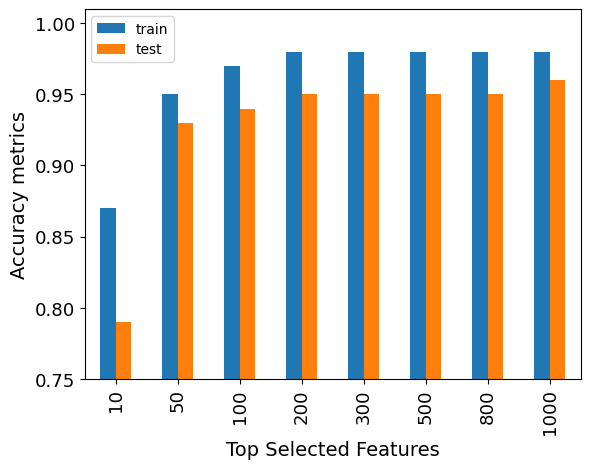

In [24]:
# conver the train-test dictionary to dataFrame
df = pd.DataFrame(data = dic).T

plt.figure( figsize=(15,4))
df.rename(columns = {0:'train', 1:'test'}, inplace=True)
# plot grouped bar chart
df.plot(kind="bar")
plt.ylim((.75,1.01))
plt.xlabel('Top Selected Features',fontsize=14)
plt.ylabel('Accuracy metrics', fontsize = 14)
plt.tick_params('both', labelsize = 13);

# Confusion Matrix

Score on training set: 0.9836633877887073
Score on testing set: 0.9555448175887895
              precision    recall  f1-score   support

           0       0.63      0.90      0.74       585
           1       0.99      0.96      0.98      7693

    accuracy                           0.96      8278
   macro avg       0.81      0.93      0.86      8278
weighted avg       0.97      0.96      0.96      8278



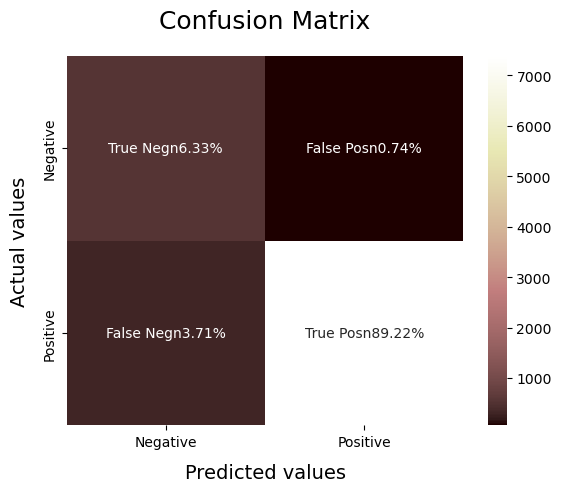

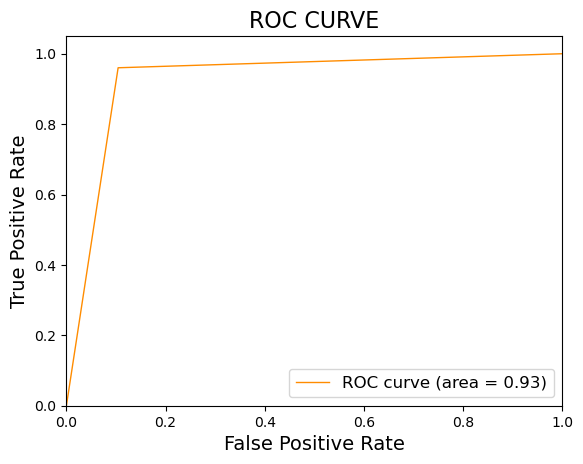

In [25]:
# View confusion matrix
model_Evaluate(xgb_2, Xcv_train_balanced2, Xcv_test_2, y_train_balanced2, y_test)

#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# PCA

In [26]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp

In [27]:
pca_model = TruncatedSVD(n_components = 100, random_state=42)
pca = pca_model.fit(Xcv_train_balanced)
Xcv_train_balanced_pca = pca.transform(Xcv_train_balanced)
Xcv_test_pca = pca.transform(Xcv_test)

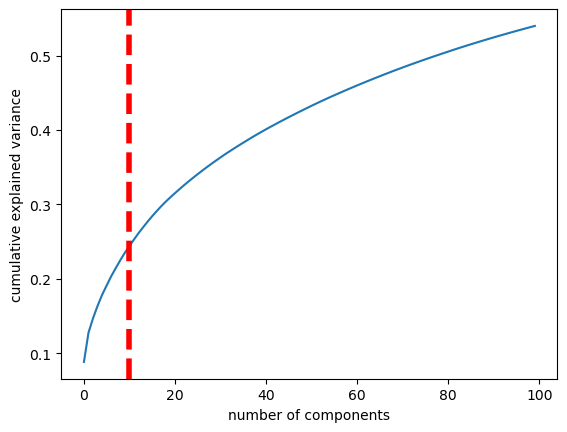

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.088504,0.088504
1,0.127870,0.039367
2,0.147253,0.019383
3,0.163975,0.016722
4,0.178796,0.014821
5,0.191409,0.012614
6,0.203762,0.012352
7,0.214741,0.010979
8,0.225335,0.010593
9,0.235391,0.010056


In [28]:
plt.figure()
#             sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_model.explained_variance_ratio_
cvr = np.cumsum(pca_model.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [29]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_model.components_, index=pca_dims)
display(pca_test_df.head(10).T)
plt.show();

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9
0,0.000205,-0.000941,0.000115,0.000117,1.263632e-03,-0.001365,1.871002e-04,1.787922e-05,-9.241875e-04,5.395244e-04
1,0.000204,-0.000942,0.000116,0.000117,1.266184e-03,-0.001364,1.872337e-04,2.112097e-05,-9.174332e-04,5.462324e-04
2,0.000001,0.000002,0.000007,0.000006,-1.129679e-06,-0.000002,-1.527525e-07,4.605358e-06,-5.412663e-07,-2.677945e-07
3,0.000098,-0.000133,-0.000063,0.000147,-2.459956e-04,0.000059,-2.599245e-06,1.163035e-04,6.354668e-06,2.326011e-04
4,0.000004,0.000010,0.000004,-0.000007,-2.367741e-06,-0.000015,9.402645e-06,-3.522151e-05,1.265775e-05,1.170343e-06
...,...,...,...,...,...,...,...,...,...,...
19873,0.000004,0.000005,-0.000007,-0.000007,-8.963964e-08,0.000002,-1.949201e-06,-3.861642e-06,-1.121710e-05,-7.557255e-06
19874,0.000003,0.000007,-0.000008,-0.000008,1.713556e-05,0.000003,7.349575e-08,9.181247e-07,1.893612e-05,1.959956e-05
19875,0.000410,0.000417,0.000169,0.000150,2.381306e-05,0.000059,-2.384673e-05,2.784974e-04,-1.461164e-04,-5.502685e-04
19876,0.000012,-0.000017,-0.000047,-0.000020,-1.773793e-05,0.000018,-1.012449e-06,-3.531586e-05,-5.223323e-05,-4.724906e-05


In [30]:
# Xcv_train_balanced_pca[:10]

In [31]:
dic_pca = {}
for top_pca_components in [1, 2, 5, 10, 15, 20, 30, 50, 100, 200]:
    pca_model = TruncatedSVD(n_components = top_pca_components, random_state=42)
    pca = pca_model.fit(Xcv_train_balanced)
    Xcv_train_balanced_pca = pca.transform(Xcv_train_balanced)
    Xcv_test_pca = pca.transform(Xcv_test)

    xgb_pca = XGBClassifier(random_state = 42)
    xgb_pca.fit(Xcv_train_balanced_pca, y_train_balanced)
    
    dic_pca[top_pca_components] = ( round(xgb_pca.score(Xcv_train_balanced_pca, y_train_balanced),2), 
                                    round(xgb_pca.score(Xcv_test_pca, y_test), 2) )

    print(top_pca_components, dic_pca[top_pca_components])

1 (0.81, 0.73)
2 (0.97, 0.93)
5 (0.99, 0.94)
10 (1.0, 0.95)
15 (1.0, 0.96)
20 (1.0, 0.96)
30 (1.0, 0.96)
50 (1.0, 0.97)
100 (1.0, 0.97)
200 (1.0, 0.97)


<Figure size 1500x400 with 0 Axes>

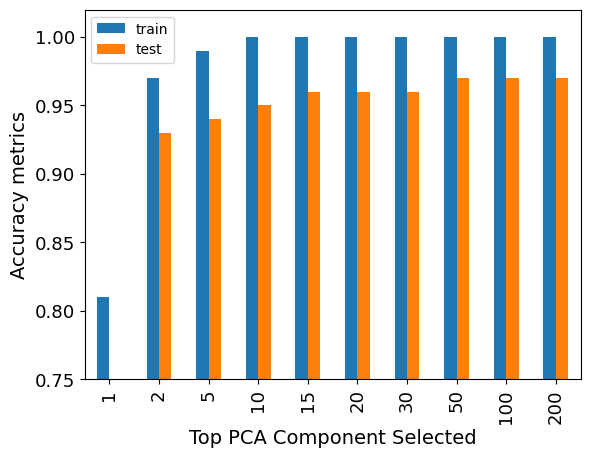

In [32]:
# conver the train-test dictionary to dataFrame
df = pd.DataFrame(data = dic_pca).T

plt.figure( figsize=(15,4))
df.rename(columns = {0:'train', 1:'test'}, inplace=True)
# plot grouped bar chart
df.plot(kind="bar")
plt.ylim((.75,1.02))
plt.xlabel('Top PCA Component Selected',fontsize=14)
plt.ylabel('Accuracy metrics', fontsize = 14)
plt.tick_params('both', labelsize = 13)

__Figure Caption__: By using 1000 components of PCA, we could increase the train and test accuracy scores up to 99% and 96%.

# Confusion Matrix

Score on training set: 0.9988950036833211
Score on testing set: 0.9697994684706451
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       585
           1       0.98      0.98      0.98      7693

    accuracy                           0.97      8278
   macro avg       0.88      0.89      0.89      8278
weighted avg       0.97      0.97      0.97      8278



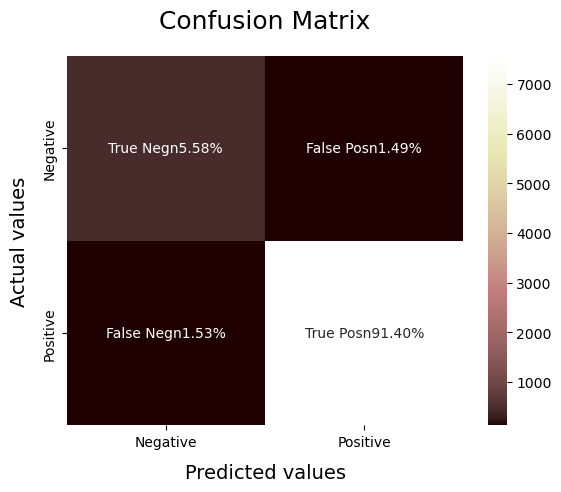

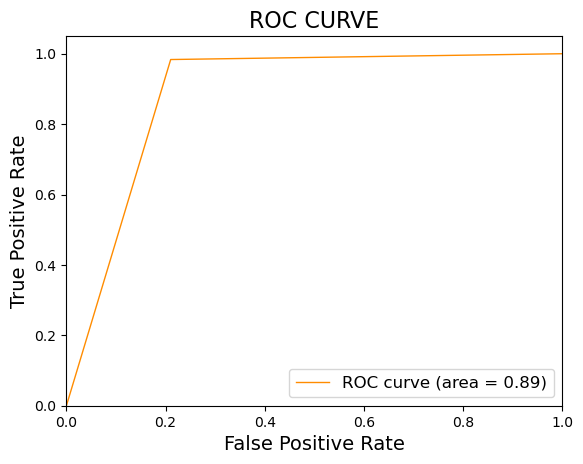

In [33]:
# View confusion matrix
model_Evaluate(xgb_pca, Xcv_train_balanced_pca, Xcv_test_pca, y_train_balanced, y_test)

# ======================================================

# Gridsearch

In [35]:
params = {
    # Parameters that we are going to tune.
#     'max_depth':6,
    'n_estimators': [100,500, 1000],
#     'eta':.3,
#     'subsample': 1,
#     'colsample_bytree': 1,
}

In [36]:
gs = GridSearchCV(XGBClassifier(random_state=42), params, cv = 5)

In [37]:
gs.fit(Xcv_train_balanced_pca, y_train_balanced)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'n_estimators': [100, 500, 1000]})

In [38]:
gs.score(Xcv_train_balanced_pca, y_train_balanced), gs.score(Xcv_test_pca, y_test)

(0.9988950036833211, 0.971490698236289)

In [39]:
gs.best_params_

{'n_estimators': 1000}

# Confusion Matrix

Score on training set: 0.9988950036833211
Score on testing set: 0.971490698236289
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       585
           1       0.98      0.99      0.98      7693

    accuracy                           0.97      8278
   macro avg       0.89      0.89      0.89      8278
weighted avg       0.97      0.97      0.97      8278



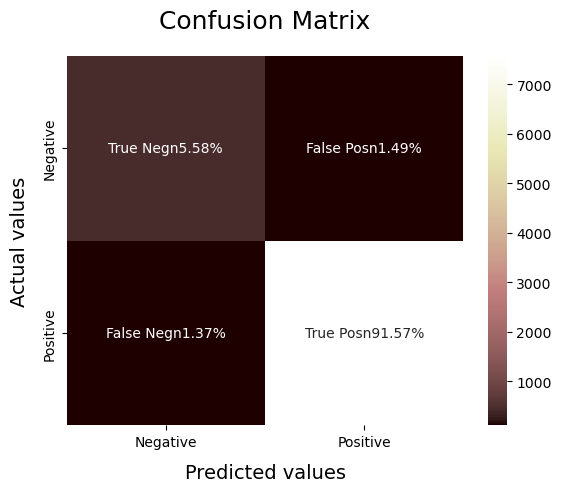

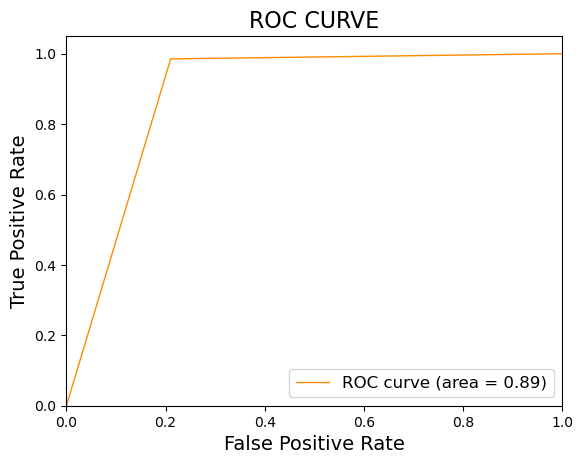

In [40]:
model_Evaluate(gs, Xcv_train_balanced_pca, Xcv_test_pca, y_train_balanced, y_test)